## Introduction

This notebook was developed to help people get started on implementing Reinforcement Learning algorithms.

This notebook could be a nice supplement to someone reading 'Reinforcement Learning - An Introduction' by Richard Sutton and Andrew Barto.

The goal of the notebook is to

- Help enthusiasts understand the effect of various hyperparameters on agent performance
- Compare various RL algorithms

The MountainCar-v0 problem is used to illustrate various key insights.

Do go through the 'classic_rl_agents.py' module to checkout the implementation of various algorithms.

Simplicity has been given priority over computational efficieny in the implementation of these algorithms to enable better understanding.

In [1]:
%matplotlib inline

import numpy as np
import time
import gym
from tqdm import tqdm

from classic_rl_agents import SARSA_agent, Expected_SARSA_agent, Q_agent, TO_SARSA_Lambda_agent
from plots import plot_var_history, ValuePlot_2D, FunctionPlot_3D

## Available Agents
        - Semi-Gradient n-step SARSA agent
        - Semi-Gradient n-step Expected SARSA agent
        - Semi-Gradient Q-Learning agent
        - True Online SARSA(lambda)

## Hyperparameters

### Tile Encoder Parameters:
        - number of tiles
        - number of tilings

### Agent Parameters:
        - step size
        - epsilon
        - number of bootstrapping steps
        - step size decay
        - lambda

In [2]:
class ValuePlot():
    """
    Class to plot the value function of the agent

    This class creates a dynamic plot of the value function over
    the training period to give insight on how the value function is learnt
    """

    def __init__(self, agent, title_key='', Dia_2D=False):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        steps = (ranges[:, 1] - ranges[:, 0])/32
        self.X = np.arange(ranges[0][0], ranges[0][1]+steps[0]/2, steps[0])
        self.Y = np.arange(ranges[1][0], ranges[1][1]+steps[1]/2, steps[1])
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)

        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'Steps to goal '+title_key}
        
        if Dia_2D:
            self.dia = ValuePlot_2D(values, mesh_X, mesh_Y, **kw_args)
        else:
            self.dia = FunctionPlot_3D(values, mesh_X, mesh_Y, **kw_args)

    def update(self, time_step, episode, episode_done):
        if (time_step % 200 == 0 and episode == 1):
            self.update_plot("after {} timesteps".format(time_step))
        elif (episode in [10, 50, 100, 200, 500, 1000, 2000, 3500, 5000] and episode_done):
            self.update_plot("after {} episodes".format(episode))

    def update_plot(self, title_key=''):
        """ Updates the agnet's value funtion plot """
        values = np.zeros((self.X.size, self.Y.size))
        tiles = np.arange(0, self.agent.tc.num_tilings, 1)
        for i in range(self.X.size):
            for j in range(self.Y.size):
                values[i][j] = -np.max(np.sum(self.agent.value_function[:, self.agent.tc.get_feature([self.X[i], self.Y[j]]), tiles], axis = 1))
        mesh_X, mesh_Y = np.meshgrid(self.X, self.Y, sparse=True)
        
        self.dia.update(values, mesh_X, mesh_Y, title=('steps to goal ' + title_key))

In [3]:
class StateFrequencyPlot():
    """
    Class to plot a color mesh indicating the frequency with which 
    the agent visits each state in the state space
    """

    def __init__(self, agent, title_key=''):
        self.agent = agent
        ranges = self.agent.tc.var_ranges
        self.left_limit = ranges[:, 0]
        self.right_limit = ranges[:, 1]
        self.steps = [0.1, 0.01]
        cell_counts = np.round((self.right_limit - self.left_limit) / self.steps)
        self.visits = np.zeros((int(cell_counts[1]), int(cell_counts[0])))
        self.X = np.round(np.arange(self.left_limit[0], self.right_limit[0] + self.steps[0]/2, self.steps[0]), 1)
        self.Y = np.round(np.arange(self.left_limit[1], self.right_limit[1] + self.steps[1]/2, self.steps[1]), 2)
        self.X, self.Y = np.meshgrid(self.X, self.Y, sparse=True)

        kw_args = {'x_label': 'Position', 'y_label': 'Velocity', 'ipython': True,
                    'title': 'state visit frequency '+title_key}

        self.dia = ValuePlot_2D(self.visits, self.X, self.Y, **kw_args)

    def update_visit_count(self, observation, time_step, episode, episode_done):
        """ Updates the visit count """
        pos = int((observation[0]-self.left_limit[0]) / self.steps[0])
        vel = int((observation[1]-self.left_limit[1]) / self.steps[1])
        self.visits[vel, pos] +=1
        if (episode in [1, 10, 25, 100, 500, 1000, 200, 3500, 5000] and episode_done):
            self.update_plot("after {} episodes".format(episode))

    def update_plot(self, title_key=''):
        """ Updates the state visit frequency plot """
        self.dia.update(self.visits, self.X, self.Y, 'state visit frequency '+title_key)


In [5]:
def run_experient(env, num_runs, num_episodes, settings,
            render_env = False, plot_value_func = False, plot_state_visit = False):
    num_actions = env.action_space.n
    obs_limits = np.transpose(np.vstack((env.observation_space.low, env.observation_space.high)))
    reward_history = []
    for i, (Agent, agent_args) in enumerate(settings):
        time.sleep(1)
        reward_history.append([])
        # Start the runs for each setting
        for run in tqdm(range(1, num_runs+1), desc="Parameter Setting {}".format(i+1)):
            reward_history[i].append([])
            env.seed(run)
            agent_args["seed"] = run
            agent = Agent(obs_limits, num_actions, **agent_args)
            # Instantiate plot for value function
            if plot_value_func:
                value_plot = ValuePlot(agent)
            # Instantiate plot for state visitation count
            if plot_state_visit:
                state_freq_plot =  StateFrequencyPlot(agent)
            # Start the episodes
            for episode in range(1, num_episodes+1):
                observation  = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                        time.sleep(0.001)
                    observation, reward, done, info = env.step(action)
                    time_step +=1
                    if done:
                        agent.end(reward)
                    else:
                        action = agent.take_step(reward, observation)
                    # Update state visits
                    if plot_state_visit:
                        state_freq_plot.update_visit_count(observation, time_step, episode, done)
                    # Plot the value function at fixed intervals
                    if plot_value_func:
                        value_plot.update(time_step, episode, done)
                reward_history[i][run-1].append(time_step)
    env.close()
    return reward_history, agent

## MountainCar-v0

Please checkout the [openai]( https://gym.openai.com/envs/MountainCar-v0/) website and ther [github](https://github.com/openai/gym/wiki/) repo for more details on the MountainCar-v0 environmnet.

#### Note: Pass render_env=True to the above function to watch the agent learn


In [3]:
# Setup environment
env = gym.make('MountainCar-v0').env
# Set plot parameters
plot_args = {'x_label': 'Episode', 'y_label': 'Steps per Episode (log scale)\n(Averaged over 50 runs)',
            'log_scale': True, 'y_ticks': [110, 125, 150, 200, 500, 1000]}

### Tile Encoding:

Tile encoding is an effective feature representation method for problems with a small state space. Though it is usually combined with a linear function approximator, the combination is capable of modelling even non-linear fuctions. The non-linearity is encapsuled in the feature vector generation.

The below experiment studies the effects of the tile encoding parameters on the agent's performance:

1. Number of Tilings
2. Number of Tiles per Tiling

Using more tilings increases resolution while also increasing computation cost.

Creating tilings with a large number of tiles slows learning by decreasing generalization. On the other hand, it increases the resolution of the tile encoder thus enabling it to differentiate the value of different states better.

The results from this experiment confirm the same, as the agent using smaller tiles learns slower. The agent performance does eventually catch up. 

Parameter Setting 6: 100%|██████████| 50/50 [18:33<00:00, 22.27s/it]


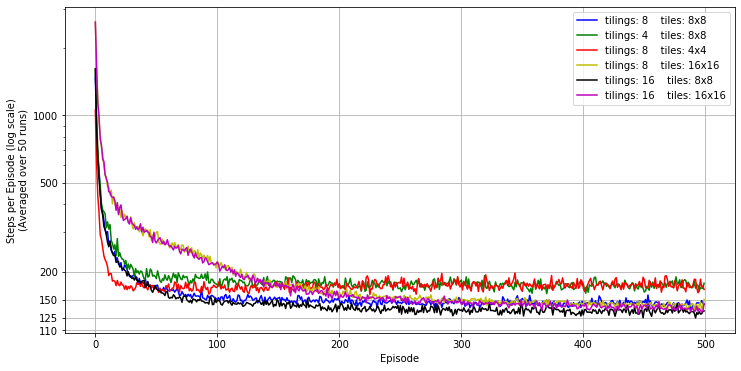

In [4]:
# Experiment to identify tile encoding hyperparameters performance

settings = [(SARSA_agent, {"num_tilings": 8, "num_tiles": [8, 8]}), 
               (SARSA_agent, {"num_tilings": 4, "num_tiles": [8, 8]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [4, 4]}),
               (SARSA_agent, {"num_tilings": 8, "num_tiles": [16, 16]}),
               (SARSA_agent, {"num_tilings": 16, "num_tiles": [8, 8]}),
               (SARSA_agent, {"num_tilings": 16, "num_tiles": [16, 16]})]

labels = ["tilings: 8    tiles: 8x8", "tilings: 4    tiles: 8x8",
          "tilings: 8    tiles: 4x4", "tilings: 8    tiles: 16x16",
          "tilings: 16    tiles: 8x8", "tilings: 16    tiles: 16x16"]

rewards_t1, agent_t1 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t1, labels, **plot_args)

### Visualizing the Agent's Value Prediction Process

The below experiment give an intuition on how the value function is learnt. The value function is intialized optimistically which aids in initial exploration. This is an effective exploration strategy for simpler function approximation methods such as tile encoding.

#### Note: The entire state-space is not accessible to the agent. For example, the agent cannot reach x=0.5 with a negative velocity. Hence those states retain the initial optimistic value of zero.

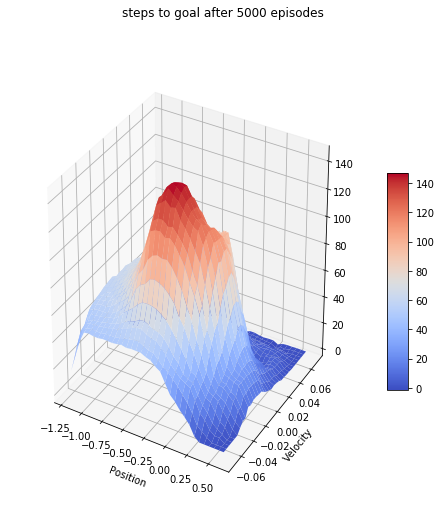

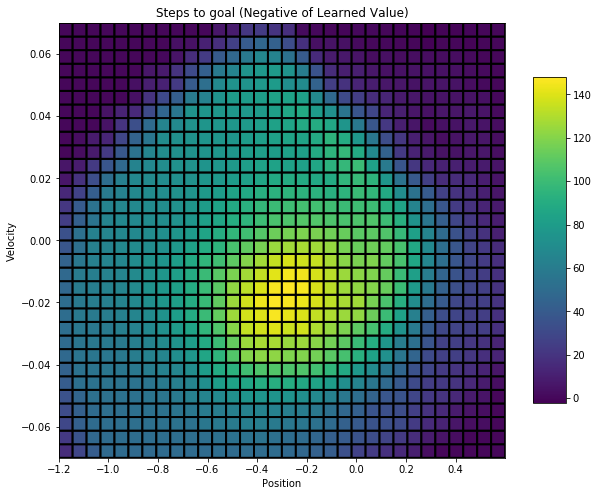

In [7]:
# Experiment to visualize the learning of the value function
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

rewards_t2, agent_t2 = run_experient(env, 1, 5000, settings,  plot_value_func = True, plot_state_visit=False)

_ = ValuePlot(agent_t2, title_key='(Negative of Learned Value)', Dia_2D=True)

### Visualizing the Agent's Policy

The below experiment helps to visualize how the agent frequents various states during learning.

100%|██████████| 1/1 [02:11<00:00, 131.40s/it]


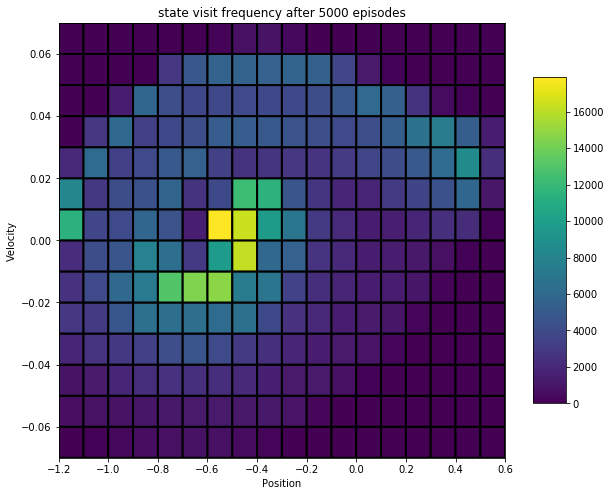

In [8]:
# Experiment to visualize agent exploration
settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5})]

rewards_t3, agent_t3 = run_experient(env, 1, 5000, settings,  plot_value_func = False, plot_state_visit=True)

### Effect of bootstrapping:

Bootstrapping is an important concept in RL. The spectrum ranges from Monte Carlo methods which use samplings and do not bootstrap at all to Temporal Difference methods which bootstrap after each step.

The optimal level of bootstrapping often lies in between.

The experiment below tests the n-step SARSA algorithm with different step strides. 

### Decaying step size

For n-step agents which bootstraps further into the future (i.e higher values of n), the performance decays after an initial period of fast learing. This can be attributed to the higher variance stemming from the increased Monte Carlo tendencies. One intuitive reason is that the agent attributes rewards even to the non-greedy exploratory steps taken on an otherwise optimal path.

Using smaller step size mitigates this issue, but leads to slower learing. Using an exponentially decaying step size turned out to be an effective solution.

Parameter Setting 4: 100%|██████████| 50/50 [11:09<00:00, 13.40s/it]


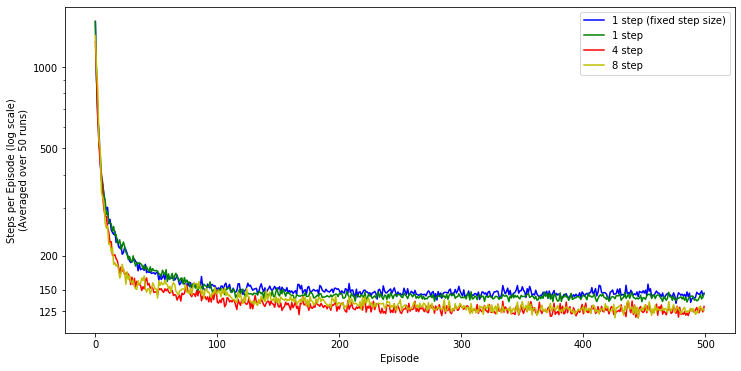

In [5]:
# Experiment to observe effect of bootstrapping in sarsa

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}),
            (SARSA_agent, {"n_step": 1, "step_size": 0.5, "decay_factor": 0.99}),
            (SARSA_agent, {"n_step": 4, "step_size": 0.4, "decay_factor": 0.99}),
            (SARSA_agent, {"n_step": 8, "step_size": 0.3, "decay_factor": 0.99})]

plot_labels = ["1 step (fixed step size)", "1 step", "4 step", "8 step"]

rewards_t4, agent_t4 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t4, plot_labels, **plot_args)

### Comparison of Classic RL Algorithms

This experiment compares the performance of SARSA, expected SARSA and Q-Learning agents.

In this particular problem, there doesn't seem to be any significant performance difference among the algorithms.

#### Note: This implementation of Q-Learning agent support only 1-step bootstrapping

Parameter Setting 1
100%|██████████| 50/50 [11:28<00:00, 13.77s/it]
Parameter Setting 2
100%|██████████| 50/50 [12:57<00:00, 15.54s/it]
Parameter Setting 3
100%|██████████| 50/50 [11:23<00:00, 13.66s/it]


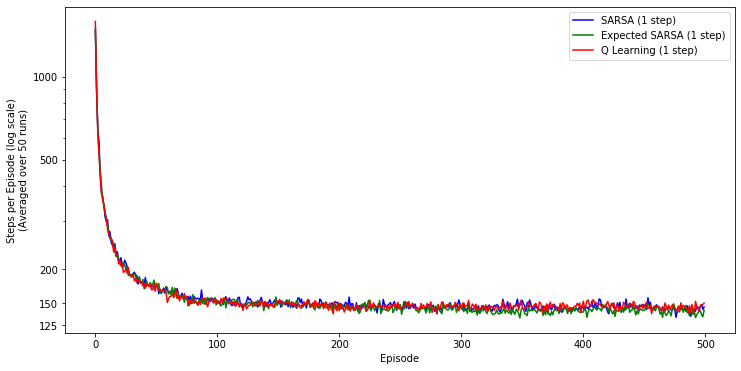

In [10]:
# Experiment to compare different Classical RL agents

settings = [(SARSA_agent, {"n_step": 1, "step_size": 0.5}), (Expected_SARSA_agent, {"n_step": 1, "step_size": 0.5}),
            (Q_agent, {"n_step": 1, "step_size": 0.5})]

plot_labels = ["SARSA (1 step)", "Expected SARSA (1 step)", "Q Learning (1 step)"]

rewards_t5, agent_t5 = run_experient(env, 50, 500, settings)

plot_var_history(rewards_t5, plot_labels, **plot_args)

## Finally, a highly optimized agent !

Finally below is a highly optimized RL agent for the MountainCar-v0 problem.

The agent runs on the True Online SARSA (lambda) algorithm. The agent uses eligibility traces (Dutch's trace) which is a powerful technique to make more directed updates. The agent keeps track of which components of the function approximator contributed to the error in the value estimates. The trace fades away as the agent moves to successive states in the trajectory. 

Another interersting fact is that the agent here looks backwards instead of the usual case where it makes updates by looking forward.

#### Note: For further study on eligibility traces, turn to the Chapter-12 of Prof. Sutton's book.

In [ ]:
settings = [(TO_SARSA_Lambda_agent, {"step_size": 0.1, "epsilon":0.001, "lambda_val": 0.9, "decay_factor": 0.99, "num_tilings": 16})]

plot_args['y_label'] = 'Steps per Episode (log scale)\n(Averaged over 100 runs)'
plot_labels = ["True Online Sarsa (lamda) Agent"]

rewards_t6, agent_t6 = run_experient(env, 100, 500, settings)

plot_var_history(rewards_t6, plot_labels, **plot_args)

CONGRATULATIONS, for coming all the way!

All the best on your RL journey moving forward! Do feel free to point out any corrections or improvements.

## Acknowledgements

A significant portion of this work is inspired from the book 'Reinforcement Learning - An Introduction (2nd Edition)' by Richard Sutton and Andrew Barto. (specifically, Chapter-10 On-policy Control with Approximation)